A better way to test your models.

# Introduction

Machine learning is an iterative process.

You will face choices about what predictive variables to use, what types of models to use, what arguments to supply to those models, etc. So far, you have made these choices in a data-driven way by measuring model quality with a validation (or holdout) set.

But there are some drawbacks to this approach. To see this, imagine you have a dataset with 5000 rows. You will typically keep about 20% of the data as a validation dataset, or 1000 rows. But this leaves some random chance in determining model scores. That is, a model might do well on one set of 1000 rows, even if it would be inaccurate on a different 1000 rows.

At an extreme, you could imagine having only 1 row of data in the validation set. If you compare alternative models, which one makes the best predictions on a single data point will be mostly a matter of luck!

In general, the larger the validation set, the less randomness (aka "noise") there is in our measure of model quality, and the more reliable it will be. Unfortunately, we can only get a large validation set by removing rows from our training data, and smaller training datasets mean worse models!

# What is cross-validation?

In cross-validation, we run our modeling process on different subsets of the data to get multiple measures of model quality.

For example, we could begin by dividing the data into 5 pieces, each 20% of the full dataset. In this case, we say that we have broken the data into 5 "folds".

<img src="https://i.imgur.com/9k60cVA.png"/>

Then, we run one experiment for each fold:

- In Experiment 1, we use the first fold as a validation (or holdout) set and everything else as training data. This gives us a measure of model quality based on a 20% holdout set.
- In Experiment 2, we hold out data from the second fold (and use everything except the second fold for training the model). The holdout set is then used to get a second estimate of model quality.
- We repeat this process, using every fold once as the holdout set. Putting this together, 100% of the data is used as holdout at some point, and we end up with a measure of model quality that is based on all of the rows in the dataset (even if we don't use all rows simultaneously).


# When should you use cross-validation?

Cross-validation gives a more accurate measure of model quality, which is especially important if you are making a lot of modeling decisions. However, it can take longer to run, because it estimates multiple models (one for each fold).

So, given these tradeoffs, when should you use each approach?

For small datasets, where extra computational burden isn't a big deal, you should run cross-validation.
For larger datasets, a single validation set is sufficient. Your code will run faster, and you may have enough data that there's little need to re-use some of it for holdout.
There's no simple threshold for what constitutes a large vs. small dataset. But if your model takes a couple minutes or less to run, it's probably worth switching to cross-validation.

Alternatively, you can run cross-validation and see if the scores for each experiment seem close. If each experiment yields the same results, a single validation set is probably sufficient.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
melb = pd.read_csv('dataset/melb_data.csv')
y = melb['Price']
# Select subset of predictors
cols_to_use = ['Rooms', 'Distance', 'Landsize', 'BuildingArea', 'YearBuilt']
x = melb[cols_to_use]

In [2]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13580 entries, 0 to 13579
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rooms         13580 non-null  int64  
 1   Distance      13580 non-null  float64
 2   Landsize      13580 non-null  float64
 3   BuildingArea  7130 non-null   float64
 4   YearBuilt     8205 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 530.6 KB


Then, we define a pipeline that uses an imputer to fill in missing values and a random forest model to make predictions.

While it's possible to do cross-validation without pipelines, it is quite difficult! Using a pipeline will make the code remarkably straightforward.

In [3]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

cols_transform = SimpleImputer()

model = RandomForestRegressor(n_estimators=50, random_state=0)

my_pipeline = Pipeline(steps=[('preprocessor', cols_transform), ('model', model)])

In [ ]:
# way kaggle does
my_pipeline = Pipeline(steps=[('preprocessor', SimpleImputer()),
                              ('model', RandomForestRegressor(n_estimators=50,
                                                              random_state=0))
                             ])

We obtain the cross-validation scores with the cross_val_score() function from scikit-learn. We set the number of folds with the cv parameter.

In [4]:
from sklearn.model_selection import cross_val_score
# Multiply by -1 since sklearn calculates *negative* MAE
scores = -1 * cross_val_score(my_pipeline, x, y,
                              cv=5,
                              scoring='neg_mean_absolute_error')

print("MAE scores:\n", scores)

MAE scores:
 [301628.7893587  303164.4782723  287298.331666   236061.84754543
 260383.45111427]


The scoring parameter chooses a measure of model quality to report: in this case, we chose negative mean absolute error (MAE). The docs for scikit-learn show a list of options.

It is a little surprising that we specify negative MAE. Scikit-learn has a convention where all metrics are defined so a high number is better. Using negatives here allows them to be consistent with that convention, though negative MAE is almost unheard of elsewhere.

We typically want a single measure of model quality to compare alternative models. So we take the average across experiments.

In [5]:
print("Average MAE score (across experiments):")
print(scores.mean())

Average MAE score (across experiments):
277707.3795913405


# Conclusion
Using cross-validation yields a much better measure of model quality, with the added benefit of cleaning up our code: note that we no longer need to keep track of separate training and validation sets. So, especially for small datasets, it's a good improvement!

# Exercise

In [8]:
data_full_train = pd.read_csv('dataset/home_data_train.csv', index_col='Id')
data_full_test = pd.read_csv('dataset/home_data_test.csv', index_col='Id')

In [9]:
# Remove rows with missing target, separate target from predictors
data_full_train.dropna(subset=['SalePrice'], axis=0, inplace=True)
y = data_full_train['SalePrice']
x = data_full_train.drop(['SalePrice'], axis=1)

In [11]:
# Select numeric columns only
cols_num = [col for col in x.columns if x[col].dtype in ['float64', 'int64']]
x = x[cols_num].copy()
test = data_full_test[cols_num].copy()
x.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
Id,,,,,,,,,,,,,,,,,,,,,
1,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,548,0,61,0,0,0,0,0,2,2008
2,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,460,298,0,0,0,0,0,0,5,2007
3,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,608,0,42,0,0,0,0,0,9,2008
4,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,642,0,35,272,0,0,0,0,2,2006
5,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,836,192,84,0,0,0,0,0,12,2008


So far, you've learned how to build pipelines with scikit-learn. For instance, the pipeline below will use SimpleImputer() to replace missing values in the data, before using RandomForestRegressor() to train a random forest model to make predictions. We set the number of trees in the random forest model with the n_estimators parameter, and setting random_state ensures reproducibility.

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor

In [13]:
my_pipeline = Pipeline(steps=[('preprocessor', SimpleImputer()),
                              ('model', RandomForestRegressor(n_estimators=50, random_state=0))])

You have also learned how to use pipelines in cross-validation. The code below uses the cross_val_score() function to obtain the mean absolute error (MAE), averaged across five different folds. Recall we set the number of folds with the cv parameter.

In [17]:
from sklearn.model_selection import cross_val_score
scores = -1 * cross_val_score(my_pipeline, x, y, cv=5, scoring='neg_mean_absolute_error')
print("Average MAE score:", scores.mean())

Average MAE score: 18276.410356164386


# Step 1: Write a useful function

In this exercise, you'll use cross-validation to select parameters for a machine learning model.

Begin by writing a function `get_score()` that reports the average (over three cross-validation folds) MAE of a machine learning pipeline that uses:
- the data in `X` and `y` to create folds,
- `SimpleImputer()` (with all parameters left as default) to replace missing values, and
- `RandomForestRegressor()` (with `random_state=0`) to fit a random forest model.

The `n_estimators` parameter supplied to `get_score()` is used when setting the number of trees in the random forest model.  

In [18]:
def get_score(n_estimators):
    """Return the average MAE over 3 CV folds of random forest model.
    
    Keyword argument:
    n_estimators -- the number of trees in the forest
    """
    my_pipeline = Pipeline(steps=[('preprocessor', SimpleImputer()), 
                                  ('model', RandomForestRegressor(n_estimators = n_estimators, random_state=0))])
   
    scores = -1 * cross_val_score(my_pipeline, X=x, y=y, cv=3, scoring='neg_mean_absolute_error')
    return scores.mean()

### kaggle solution

def get_score(n_estimators):

    my_pipeline = Pipeline(steps=[
    
        ('preprocessor', SimpleImputer()),
        
        ('model', RandomForestRegressor(n_estimators, random_state=0))
        
    ])
    
    scores = -1 * cross_val_score(my_pipeline, X, y,
                                  cv=3,
                                  scoring='neg_mean_absolute_error')
                                  
    return scores.mean()

# Step 2: Test different parameter values

Now, you will use the function that you defined in Step 1 to evaluate the model performance corresponding to eight different values for the number of trees in the random forest: 50, 100, 150, ..., 300, 350, 400.

Store your results in a Python dictionary `results`, where `results[i]` is the average MAE returned by `get_score(i)`.

In [30]:
results = {}

for i in range(50, 401, 50):
    results[i] = get_score(i)

results

{50: 18353.8393511688,
 100: 18395.2151680032,
 150: 18288.730020956387,
 200: 18248.345889801505,
 250: 18255.26922247291,
 300: 18275.241922621914,
 350: 18270.29183308043,
 400: 18270.197974402367}

## Kaggle Solution

results = {} 

for i in range(1,9):

    results[50*i] = get_score(50*i)
    
Use the next cell to visualize your results from Step 2. Run the code without changes.

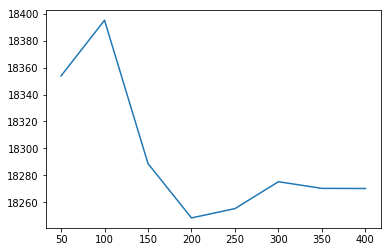

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(list(results.keys()), list(results.values()))
plt.show()

# Step 3: Find the best parameter value

Given the results, which value for `n_estimators` seems best for the random forest model?  Use your answer to set the value of `n_estimators_best`.

In [35]:
n_estimators_best = min(results, key=results.get)
n_estimators_best

200